Auto Encoder


*   Relu
*   27 --> 18 --> |16| --> 18 --> 27
*   Raw Score: 47.31851851851851
*   Grade: Moderate
*   Score: 47
*   Patient ID: SB-001
*   Batch Norm: No



In [1]:
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# Load Data
df_am = pd.read_csv('SB-001_normalized_AM.csv')
df_pm = pd.read_csv('SB-001_normalized_PM.csv')
FILE_NAME  = "Auto Encoder-L27_18_16-S47-ALRelu-E200-Psb001-BNn"
PATIENT_ID = "SB-001"
combined_df = pd.concat([df_am, df_pm])

columns_needed = ['income', 'road_dist', 'cooking', 'y_am_pef', 'tempin', 'humidin', 'pm25in', 'co2in', 'tempdiffin', 'humidiffin', 'pm25diffin', 'pm10', 'pm25', 'o3', 'no2', 'co', 'so2', 'temp', 'windsd', 'humid', 'varp', 'dewpt', 'airp', 'seap', 'solrhr', 'solramnt', 'grdt', 'class']
combined_df = combined_df.filter(columns_needed)
df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,income,road_dist,cooking,y_am_pef,tempin,humidin,pm25in,co2in,tempdiffin,humidiffin,...,windsd,humid,varp,dewpt,airp,seap,solrhr,solramnt,grdt,class
0,0.0,0.5,0.5,NaN,0.247,0.170,0.324,0.158,0.749,0.410,...,0.384,0.280,0.061,0.231,0.602,0.611,0.781,0.299,0.194,1.0
1,0.0,0.5,0.5,NaN,0.577,0.630,0.318,0.512,0.103,0.627,...,0.038,0.442,0.497,0.760,0.528,0.517,0.898,0.844,0.844,1.0
2,0.0,0.5,0.5,NaN,0.282,0.314,0.389,0.419,0.555,0.105,...,0.275,0.687,0.209,0.505,0.902,0.895,0.448,0.132,0.240,1.0
3,0.0,0.5,0.5,0.421,0.431,0.283,0.231,0.083,0.421,0.588,...,0.799,0.197,0.181,0.461,0.372,0.373,0.927,0.807,0.452,1.0
4,0.0,0.5,0.5,0.350,0.597,0.647,0.599,0.439,0.338,0.276,...,0.034,0.798,0.479,0.746,0.564,0.557,0.614,0.648,0.645,1.0


In [3]:
# Drop NaN
df = df.dropna()
print(len(df))

# Minotity Split
class_counts = df['class'].value_counts()
minority_class = df[df['class'] == 0]
majority_class = df[df['class'] == 1]

188


In [4]:
# Removing class column from minority before augmentation
X = minority_class.drop('class', axis=1)
y = minority_class['class']

# Saving minority as X_train
X_train = X
print(X_train.shape)

(57, 27)


In [5]:
X_train.head()

,income,road_dist,cooking,y_am_pef,tempin,humidin,pm25in,co2in,tempdiffin,humidiffin,...,temp,windsd,humid,varp,dewpt,airp,seap,solrhr,solramnt,grdt
6,0.0,0.5,0.5,0.268,0.851,0.660,0.154,0.628,0.247,0.455,...,0.822,0.484,0.643,0.581,0.804,0.486,0.475,0.246,0.399,0.694
7,0.0,0.5,0.5,0.415,0.425,0.253,0.342,0.344,0.585,0.346,...,0.430,0.038,0.394,0.164,0.427,0.842,0.836,0.156,0.120,0.272
17,0.0,0.5,0.5,0.310,0.556,0.429,0.796,0.357,0.576,0.310,...,0.466,0.107,0.580,0.218,0.512,0.662,0.658,0.394,0.223,0.291
23,0.0,0.5,0.5,0.284,0.813,0.749,0.291,0.384,0.154,0.396,...,0.898,0.226,0.774,0.772,0.906,0.536,0.518,0.311,0.202,0.836
25,0.0,0.5,0.5,0.228,0.143,0.000,0.108,0.146,0.992,0.445,...,0.007,0.806,0.086,0.000,0.000,0.896,0.906,0.787,0.286,0.021


In [6]:
# Check no NaN exists
nan_count = X_train.isna().sum()
columns_with_nan = nan_count[nan_count > 0]

print("Columns with NaN values:")
print(columns_with_nan)

Columns with NaN values:
Series([], dtype: int64)


In [7]:
# Define the Input shape
INPUT_SHAPE = X_train.shape[1]
INPUT_SHAPE

27

In [8]:
# Auto Encoder Model

encoder_input = keras.Input(shape=(27,), name="input")
x = keras.layers.Flatten()(encoder_input)
dense1 = keras.layers.Dense(18, activation="relu")(x)
encoder_output = keras.layers.Dense(16, activation="relu")(dense1)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
decoder_input = keras.layers.Dense(27, activation="relu")(encoder_output)
decoder_output = tf.reshape(decoder_input, (-1, 1, 27))  # Update the shape here

opt = keras.optimizers.Adam(learning_rate=0.001)
autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
decoder = keras.Model(decoder_input, decoder_output)
autoencoder.summary()

#27 --> 18 --> |16| --> 27 --> 27

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 27)]              0         
                                                                 
 flatten (Flatten)           (None, 27)                0         
                                                                 
 dense (Dense)               (None, 18)                504       
                                                                 
 dense_1 (Dense)             (None, 16)                304       
                                                                 
 dense_2 (Dense)             (None, 27)                459       
                                                                 
 tf.reshape (TFOpLambda)     (None, 1, 27)             0         
                                                                 
Total params: 1,267
Trainable params: 1,267
Non-trainab

In [9]:
autoencoder.compile(opt, loss = "mse")

In [10]:
history = autoencoder.fit(X_train, X_train, epochs=200, batch_size = 16, validation_split = 0.1)

Epoch 1/200
4/4 [==============================] - 2s 161ms/step - loss: 0.1739 - val_loss: 0.1543
Epoch 2/200
4/4 [==============================] - 0s 17ms/step - loss: 0.1671 - val_loss: 0.1480
Epoch 3/200
4/4 [==============================] - 0s 17ms/step - loss: 0.1602 - val_loss: 0.1411
Epoch 4/200
4/4 [==============================] - 0s 15ms/step - loss: 0.1527 - val_loss: 0.1339
Epoch 5/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1448 - val_loss: 0.1270
Epoch 6/200
4/4 [==============================] - 0s 17ms/step - loss: 0.1369 - val_loss: 0.1201
Epoch 7/200
4/4 [==============================] - 0s 20ms/step - loss: 0.1279 - val_loss: 0.1126
Epoch 8/200
4/4 [==============================] - 0s 21ms/step - loss: 0.1196 - val_loss: 0.1045
Epoch 9/200
4/4 [==============================] - 0s 27ms/step - loss: 0.1101 - val_loss: 0.0968
Epoch 10/200
4/4 [==============================] - 0s 24ms/step - loss: 0.1032 - val_loss: 0.0906
Epoch 11/200
4/4 [

In [12]:
#Saving history
import pickle

with open( FILE_NAME + '_history' + '.pickle', 'wb') as file:
    pickle.dump(history.history, file)

# with open('history_Auto Encoder_Leaky RELU-40.pickle', 'rb') as file:
#     history = pickle.load(file)

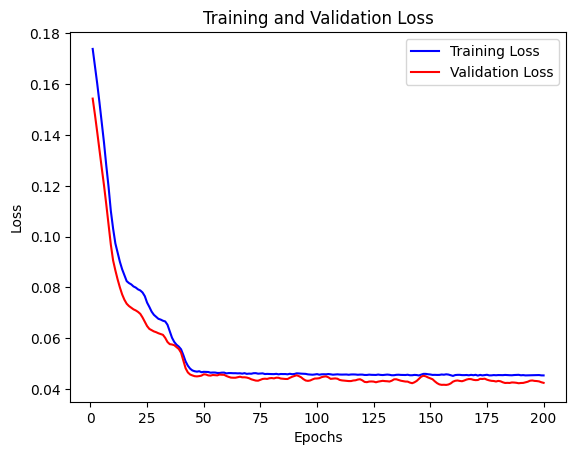

In [11]:
# Visualize losses *(MSE)
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# Difference in majority and minority class:
# We balance the dataset by generating no(synthetic data), in a way such that, after augmentation
# len(majority_class) would = len (minority_class)
difference = len(majority_class) - len(minority_class)
print(difference)

74


In [14]:
# Generating synthetic data as much as training data
# keeing data points same for report generation later
num_samples = len(X_train)
input_data = np.random.normal(size=(num_samples, 27)) # <-------

generated_data = autoencoder.predict(input_data) # <-------
generated_data.shape

2/2 [==============================] - 0s 5ms/step


(57, 1, 27)

In [15]:
# Re shape data
reshaped_data = generated_data.reshape(num_samples, -1)

# Convert it to a DataFrame
df_generated = pd.DataFrame(reshaped_data, columns=X_train.columns)

# Display the dataframe
df_generated.head(3)

,income,road_dist,cooking,y_am_pef,tempin,humidin,pm25in,co2in,tempdiffin,humidiffin,...,temp,windsd,humid,varp,dewpt,airp,seap,solrhr,solramnt,grdt
0,0.0,0.115761,0.579561,0.150873,0.615308,0.184818,0.250816,0.0,0.142913,0.388550,...,0.520867,0.213012,0.000000,0.488141,0.115802,0.626433,0.207601,0.758985,0.016791,0.157132
1,0.0,0.271075,0.613001,0.098866,0.442108,0.068526,0.203627,0.0,0.315526,0.339955,...,0.332304,0.329463,0.063290,0.145596,0.315700,0.614966,0.386653,0.432188,0.161382,0.288422
2,0.0,0.394032,0.348583,0.492521,0.875530,0.255445,0.522702,0.0,1.131591,1.265716,...,0.561078,0.323151,0.502972,0.230856,0.451580,0.789353,0.438734,0.646945,0.980435,0.777791


In [16]:
print("Minority data shape:", X_train.shape)
print("Synthetic generated data shape:", df_generated.shape)

Minority data shape: (57, 27)
Synthetic generated data shape: (57, 27)


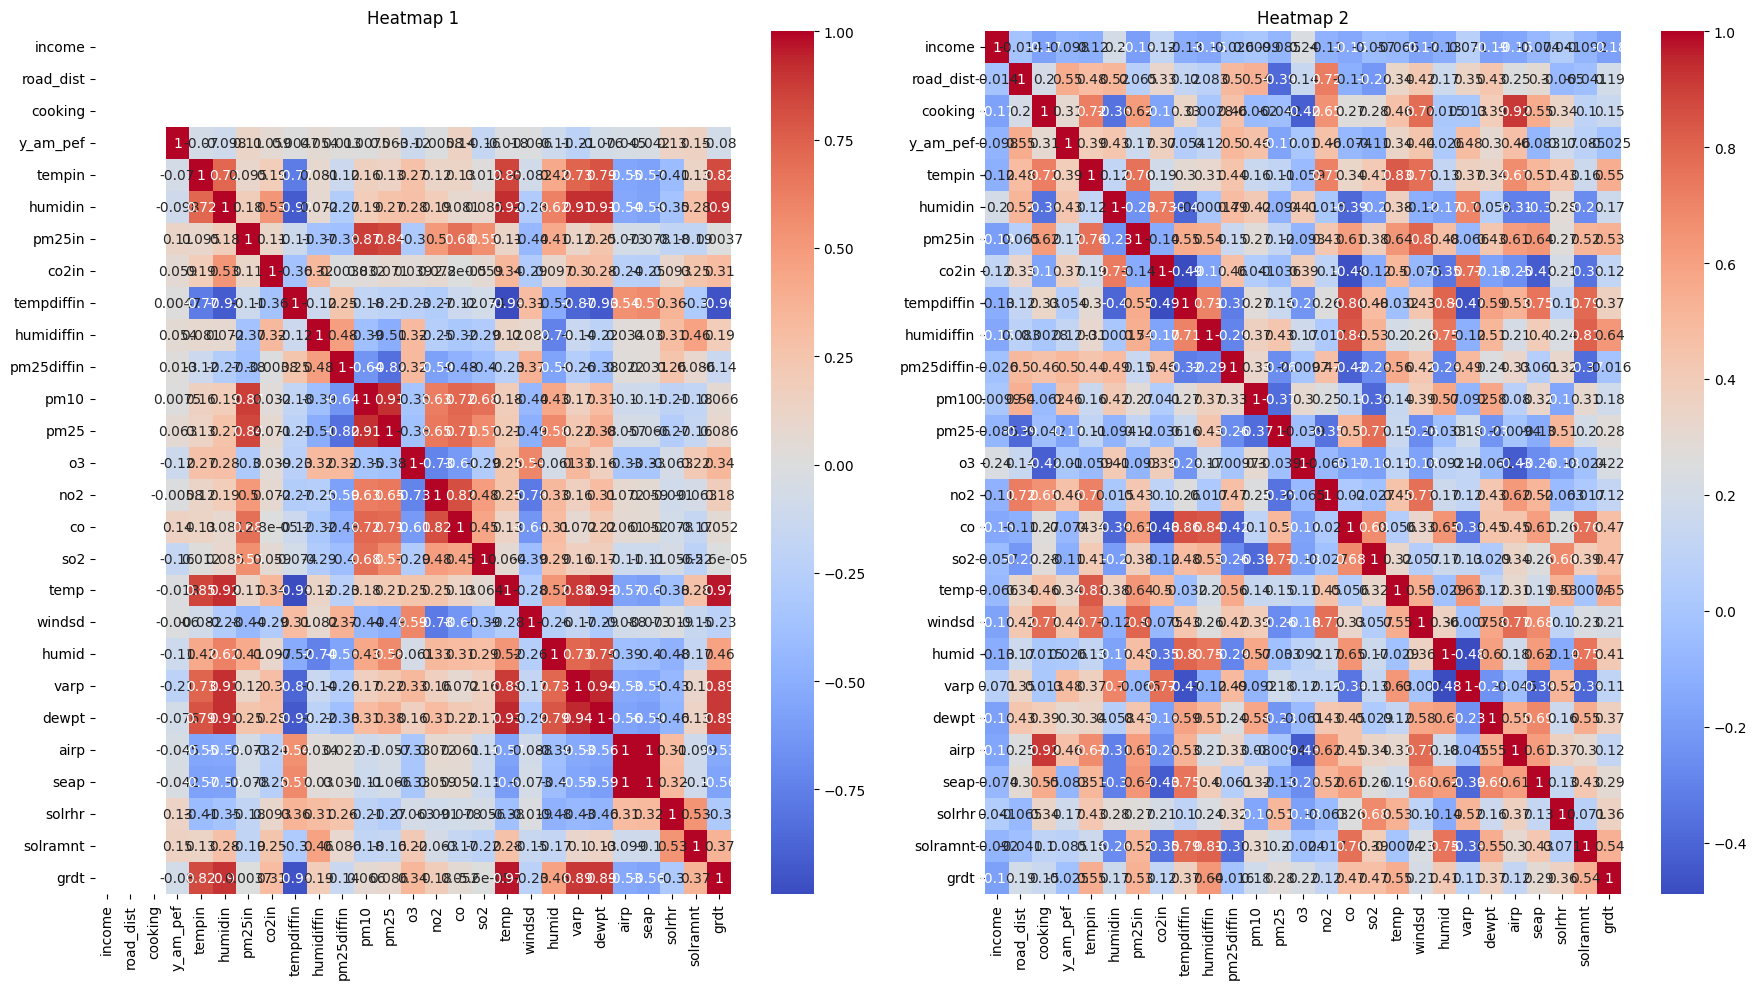

In [17]:
# Plot the Co-relation matrix
corr_matrix1 = X_train.corr()
corr_matrix2 = df_generated.corr()

fig, axes = plt.subplots(1, 2, figsize=(18, 10))
sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Heatmap 1')

sns.heatmap(corr_matrix2, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Heatmap 2')

plt.tight_layout()

plt.show()

In [18]:
# Calculating mean and standard deviation of original and synthetic dataset
common_columns = set(X_train.columns) & set(df_generated.columns)
results = {}

for column in common_columns:

    mean_df1 = X_train[column].mean()
    std_df1 = X_train[column].std()
    mean_df2 = df_generated[column].mean()
    std_df2 = df_generated[column].std()


    results[column] = {'Mean_df1': mean_df1, 'Std_df1': std_df1,
                       'Mean_df2': mean_df2, 'Std_df2': std_df2}


comparison_df = pd.DataFrame(results)

# Display the comparison dataframe
print(comparison_df)

           humidin       no2  pm25diffin      airp       so2    solrhr  \
Mean_df1  0.356877  0.302667    0.451018  0.651579  0.266860  0.547509   
Std_df1   0.184544  0.224674    0.123570  0.177173  0.142201  0.264203   
Mean_df2  0.322359  0.306829    0.369353  0.732892  0.415392  0.529944   
Std_df2   0.288127  0.297700    0.274413  0.487977  0.267773  0.257014   

          solramnt      pm25    pm25in      temp  ...    windsd     dewpt  \
Mean_df1  0.292614  0.262298  0.308474  0.458368  ...  0.364246  0.436825   
Std_df1   0.168519  0.235978  0.174530  0.219518  ...  0.258312  0.216589   
Mean_df2  0.158134  0.111719  0.353151  0.602954  ...  0.486683  0.245617   
Std_df2   0.231512  0.177331  0.253875  0.272531  ...  0.311139  0.177766   

          tempdiffin        co  y_am_pef     humid      varp      seap  \
Mean_df1    0.575035  0.309333  0.299105  0.388579  0.212842  0.649105   
Std_df1     0.204747  0.204789  0.094818  0.235243  0.180177  0.177951   
Mean_df2    0.415674 

In [19]:
comparison_df.to_csv(FILE_NAME +'_mean&std.csv', index=True)

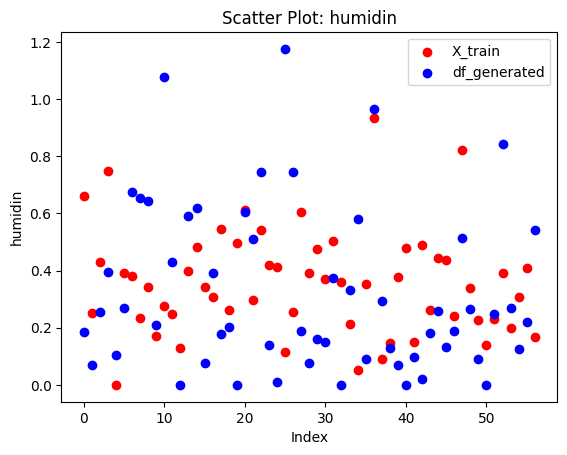

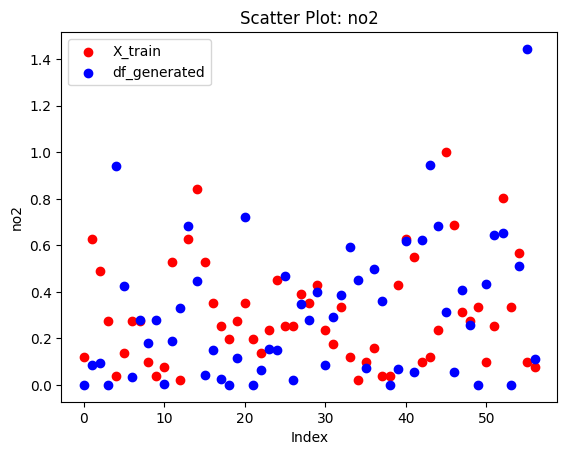

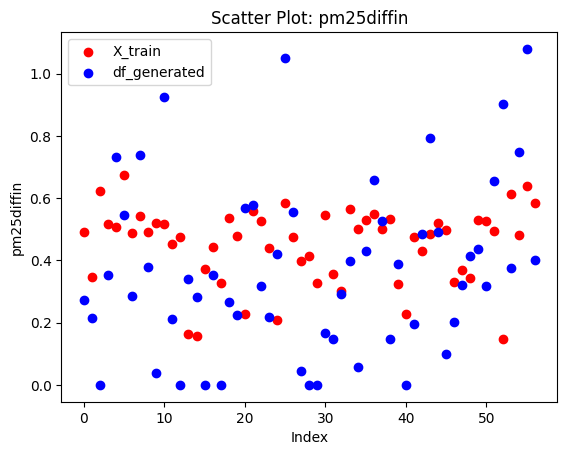

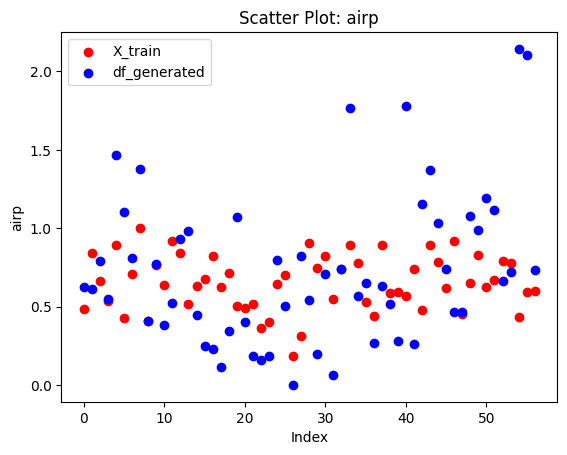

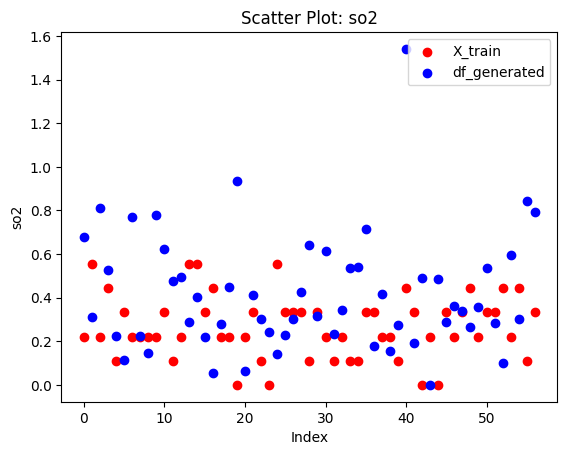

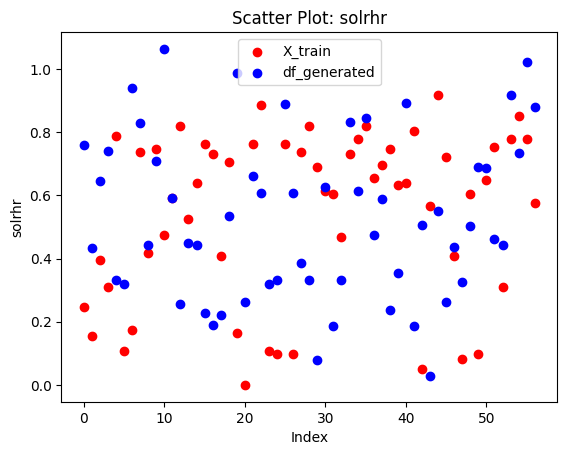

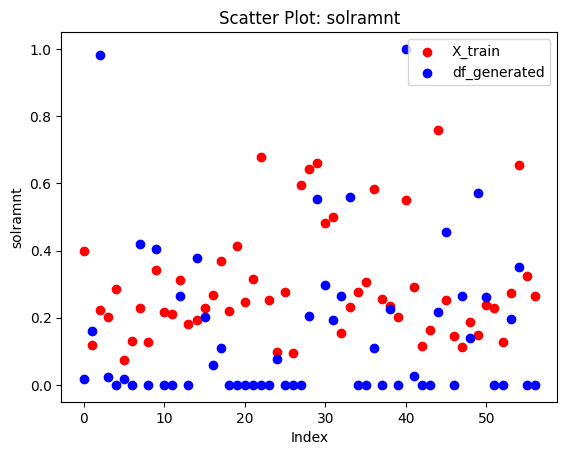

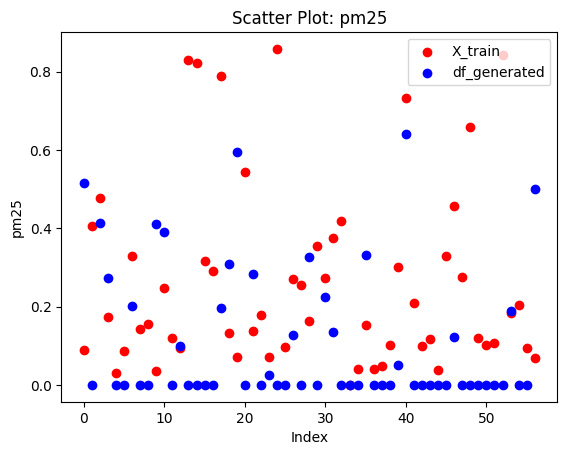

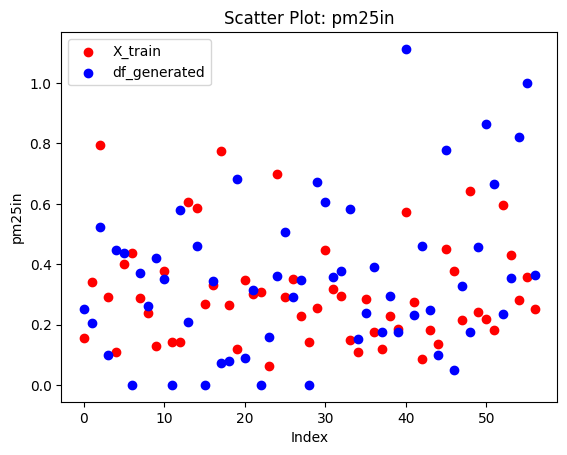

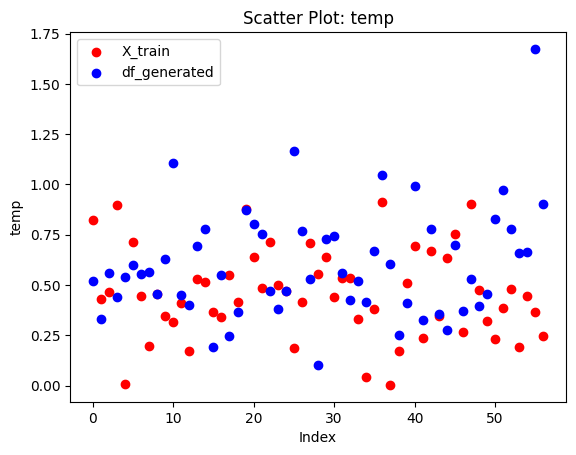

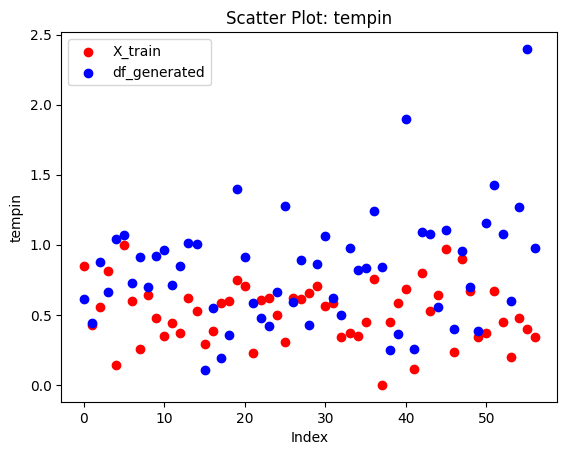

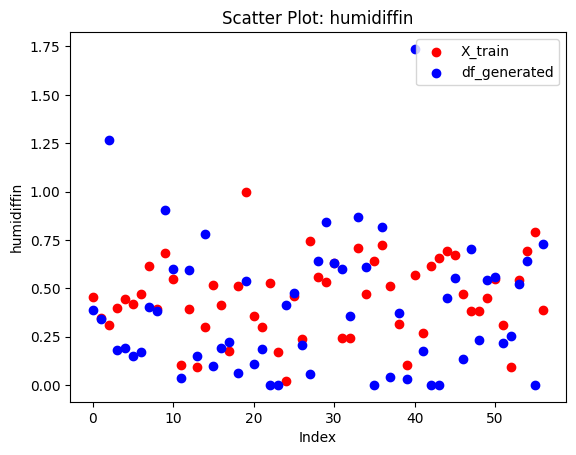

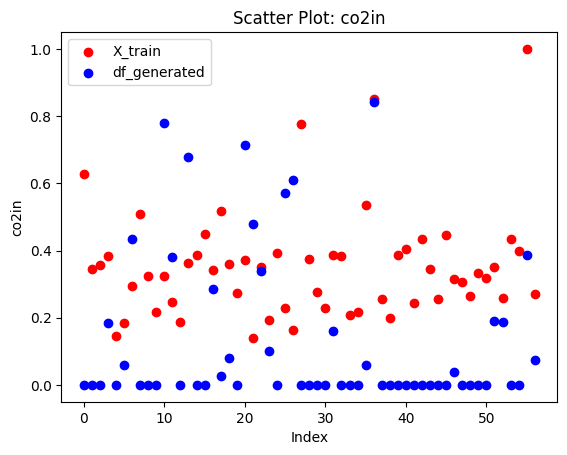

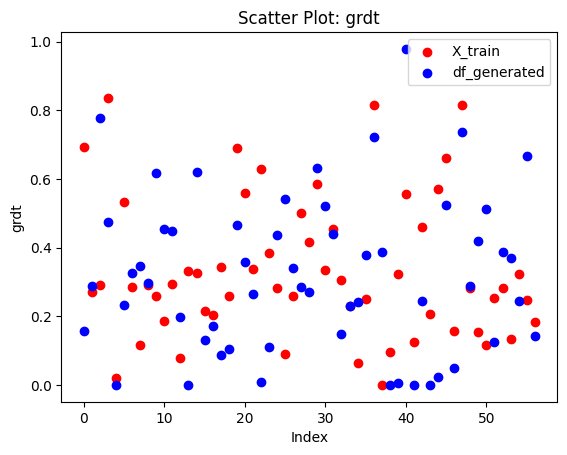

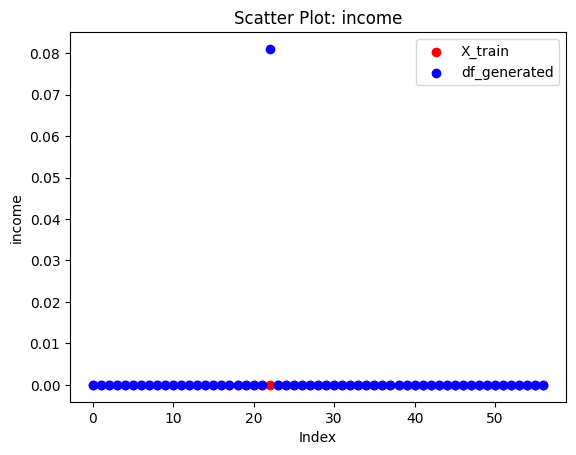

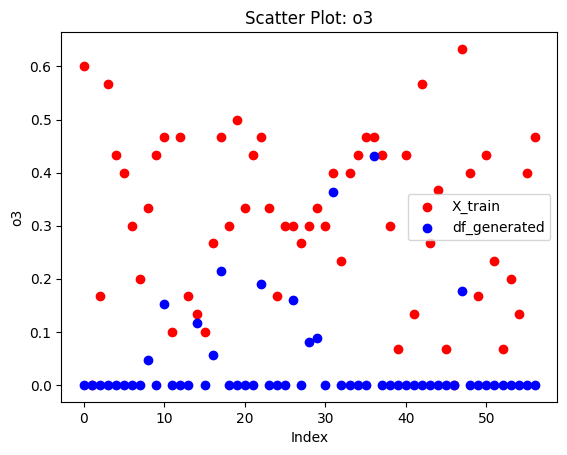

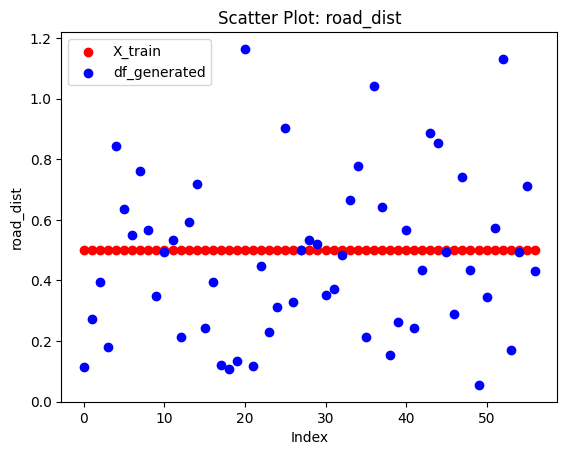

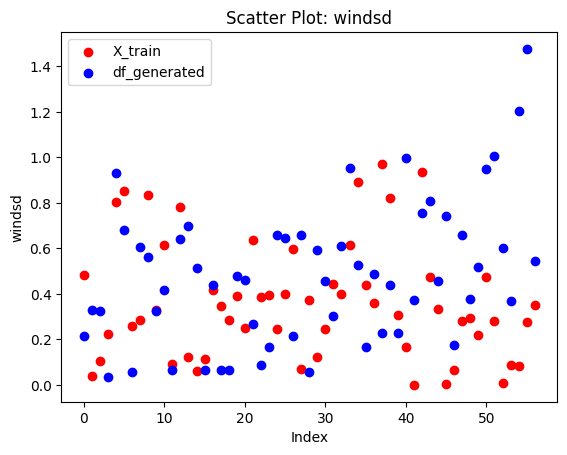

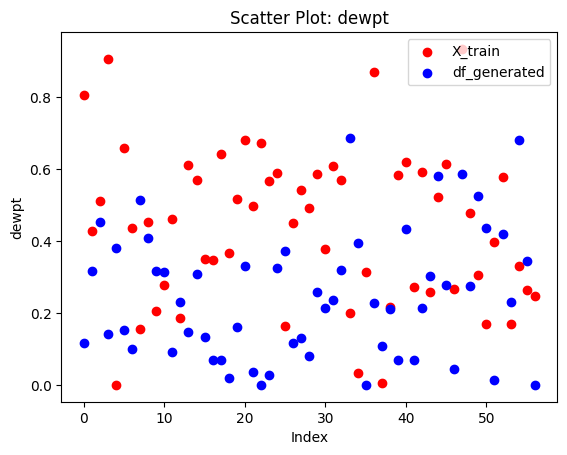

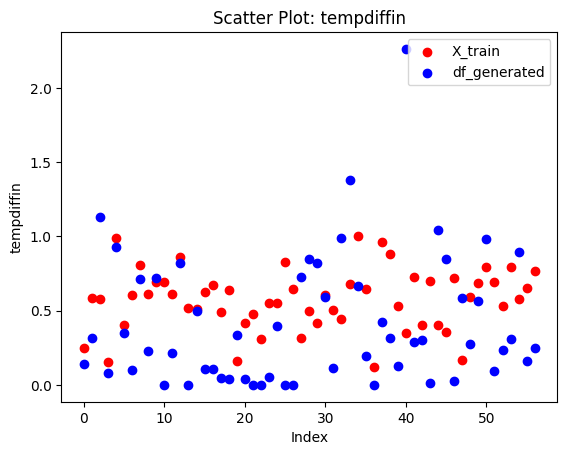

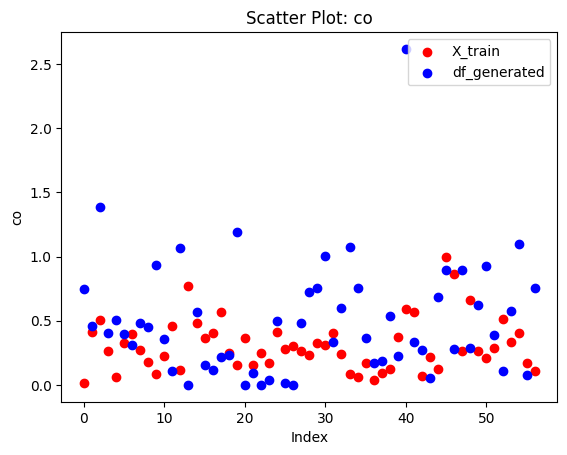

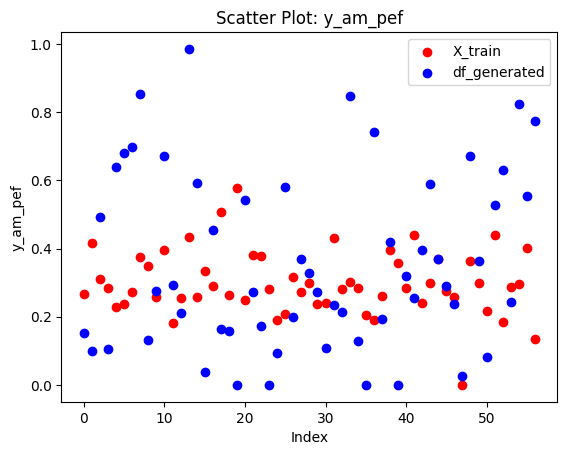

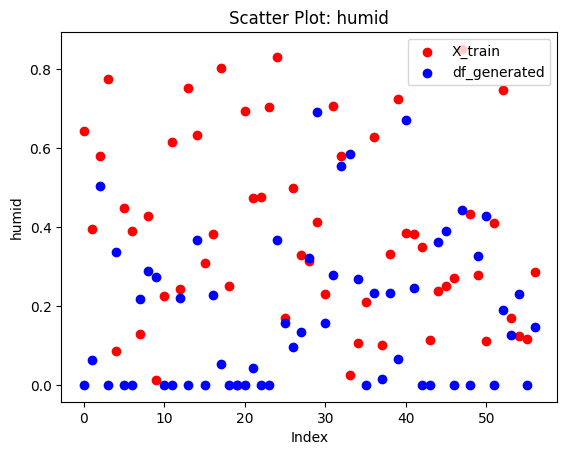

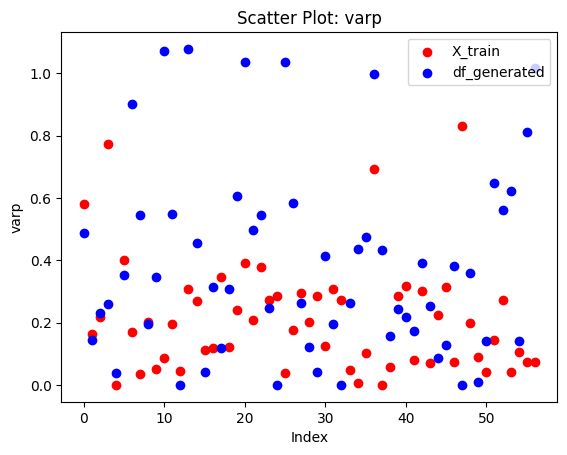

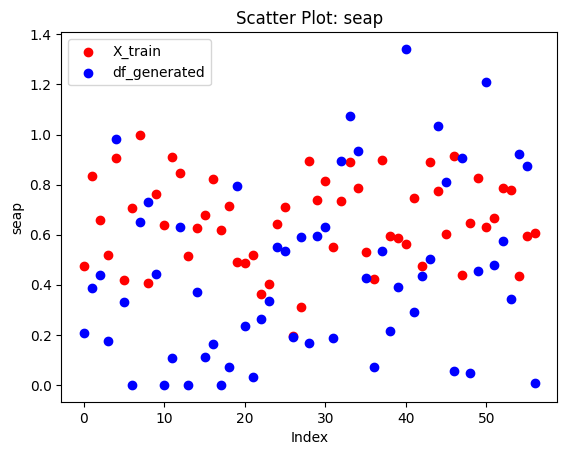

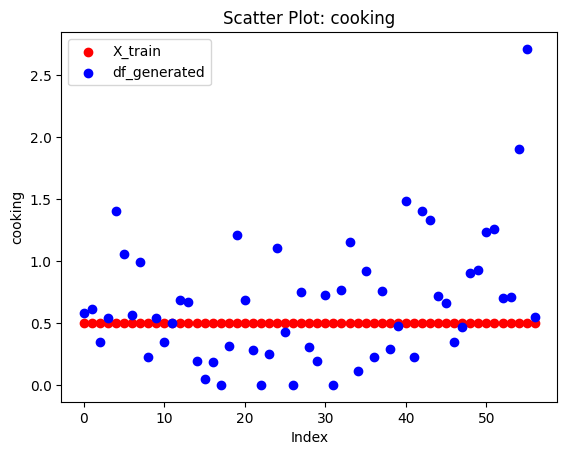

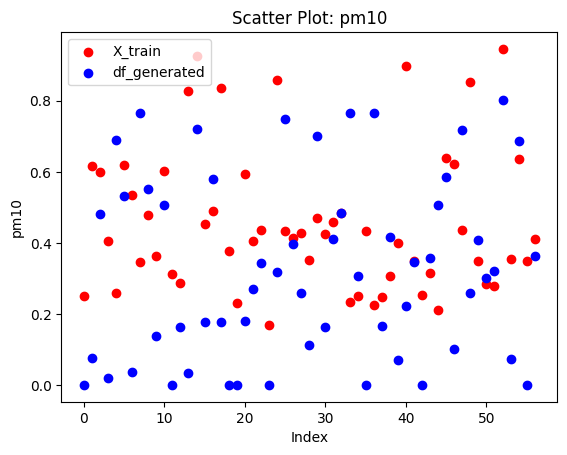

In [20]:
new_index = pd.RangeIndex(start=0, stop=57, step=1)
X_train = X_train.set_index(new_index)

import matplotlib.pyplot as plt

common_columns = set(X_train.columns) & set(df_generated.columns)
for column in common_columns:

    plt.scatter(X_train.index, X_train[column], color='red', label='X_train')
    plt.scatter(df_generated.index, df_generated[column], color='blue', label='df_generated')

    plt.title(f"Scatter Plot: {column}")
    plt.xlabel("Index")
    plt.ylabel(column)

    plt.legend()
    plt.show()

In [21]:
X_train.head()

,income,road_dist,cooking,y_am_pef,tempin,humidin,pm25in,co2in,tempdiffin,humidiffin,...,temp,windsd,humid,varp,dewpt,airp,seap,solrhr,solramnt,grdt
0,0.0,0.5,0.5,0.268,0.851,0.660,0.154,0.628,0.247,0.455,...,0.822,0.484,0.643,0.581,0.804,0.486,0.475,0.246,0.399,0.694
1,0.0,0.5,0.5,0.415,0.425,0.253,0.342,0.344,0.585,0.346,...,0.430,0.038,0.394,0.164,0.427,0.842,0.836,0.156,0.120,0.272
2,0.0,0.5,0.5,0.310,0.556,0.429,0.796,0.357,0.576,0.310,...,0.466,0.107,0.580,0.218,0.512,0.662,0.658,0.394,0.223,0.291
3,0.0,0.5,0.5,0.284,0.813,0.749,0.291,0.384,0.154,0.396,...,0.898,0.226,0.774,0.772,0.906,0.536,0.518,0.311,0.202,0.836
4,0.0,0.5,0.5,0.228,0.143,0.000,0.108,0.146,0.992,0.445,...,0.007,0.806,0.086,0.000,0.000,0.896,0.906,0.787,0.286,0.021


In [22]:
df_generated.head()

,income,road_dist,cooking,y_am_pef,tempin,humidin,pm25in,co2in,tempdiffin,humidiffin,...,temp,windsd,humid,varp,dewpt,airp,seap,solrhr,solramnt,grdt
0,0.0,0.115761,0.579561,0.150873,0.615308,0.184818,0.250816,0.000000,0.142913,0.388550,...,0.520867,0.213012,0.000000,0.488141,0.115802,0.626433,0.207601,0.758985,0.016791,0.157132
1,0.0,0.271075,0.613001,0.098866,0.442108,0.068526,0.203627,0.000000,0.315526,0.339955,...,0.332304,0.329463,0.063290,0.145596,0.315700,0.614966,0.386653,0.432188,0.161382,0.288422
2,0.0,0.394032,0.348583,0.492521,0.875530,0.255445,0.522702,0.000000,1.131591,1.265716,...,0.561078,0.323151,0.502972,0.230856,0.451580,0.789353,0.438734,0.646945,0.980435,0.777791
3,0.0,0.179817,0.536032,0.105834,0.659848,0.393311,0.099569,0.183321,0.083495,0.180274,...,0.440830,0.035930,0.000000,0.259112,0.140154,0.548169,0.173970,0.739788,0.024213,0.474339
4,0.0,0.843097,1.400441,0.638379,1.042328,0.103460,0.446102,0.000000,0.926015,0.190785,...,0.541944,0.932507,0.337778,0.037338,0.379156,1.466352,0.982587,0.331996,0.000000,0.000000


In [23]:
# Replace the necessary columns
df_generated['income'] = X_train['income'].iloc[0]
df_generated['road_dist'] = X_train['road_dist'].iloc[0]
df_generated['cooking'] = X_train['cooking'].iloc[0]

In [24]:
# Adding back the class label
X_train['class'] = 0.0
df_generated['class'] = 0.0

In [25]:
X_train.to_csv(FILE_NAME +'_Original_minority_data.csv', index=False)
df_generated.to_csv(FILE_NAME + '_Synthetic_minority_data.csv', index=False)

In [26]:
# Synthetic Data Evaluation ## GRETEL.ai
# https://console.gretel.ai/login/
# https://console.gretel.ai/users/me/key

In [27]:
%%capture
!pip install -U gretel-client

In [28]:
import pandas as pd
from gretel_client.config import RunnerMode
from gretel_client.evaluation.quality_report import QualityReport
from gretel_client import configure_session
from gretel_client.projects import create_or_get_unique_project

# Specify your Gretel API Key

pd.set_option("max_colwidth", None)
configure_session(api_key="prompt", cache="yes", validate=True)

Gretel Api Key··········
Caching Gretel config to disk.
Using endpoint https://api.gretel.cloud
Logged in as sbhuvaji@seattleu.edu ✅


In [29]:
# Load and preview real-world data
real_data = FILE_NAME +'_Original_minority_data.csv'

real_df = pd.read_csv(real_data)
real_df

,income,road_dist,cooking,y_am_pef,tempin,humidin,pm25in,co2in,tempdiffin,humidiffin,...,windsd,humid,varp,dewpt,airp,seap,solrhr,solramnt,grdt,class
0,0.0,0.5,0.5,0.268,0.851,0.660,0.154,0.628,0.247,0.455,...,0.484,0.643,0.581,0.804,0.486,0.475,0.246,0.399,0.694,0.0
1,0.0,0.5,0.5,0.415,0.425,0.253,0.342,0.344,0.585,0.346,...,0.038,0.394,0.164,0.427,0.842,0.836,0.156,0.120,0.272,0.0
2,0.0,0.5,0.5,0.310,0.556,0.429,0.796,0.357,0.576,0.310,...,0.107,0.580,0.218,0.512,0.662,0.658,0.394,0.223,0.291,0.0
3,0.0,0.5,0.5,0.284,0.813,0.749,0.291,0.384,0.154,0.396,...,0.226,0.774,0.772,0.906,0.536,0.518,0.311,0.202,0.836,0.0
4,0.0,0.5,0.5,0.228,0.143,0.000,0.108,0.146,0.992,0.445,...,0.806,0.086,0.000,0.000,0.896,0.906,0.787,0.286,0.021,0.0
5,0.0,0.5,0.5,0.237,1.000,0.393,0.399,0.183,0.403,0.418,...,0.852,0.448,0.400,0.659,0.428,0.420,0.106,0.073,0.534,0.0
6,0.0,0.5,0.5,0.273,0.598,0.380,0.437,0.293,0.606,0.468,...,0.260,0.391,0.170,0.437,0.709,0.705,0.173,0.130,0.284,0.0
7,0.0,0.5,0.5,0.375,0.257,0.234,0.287,0.509,0.807,0.615,...,0.285,0.129,0.035,0.156,1.000,1.000,0.738,0.230,0.116,0.0
8,0.0,0.5,0.5,0.348,0.644,0.342,0.239,0.323,0.610,0.394,...,0.834,0.427,0.203,0.453,0.407,0.409,0.417,0.127,0.291,0.0
9,0.0,0.5,0.5,0.257,0.474,0.170,0.130,0.218,0.691,0.683,...,0.330,0.012,0.052,0.204,0.766,0.764,0.746,0.342,0.258,0.0


In [30]:
# Load and preview synthetic data
synth_data = FILE_NAME + '_Synthetic_minority_data.csv'

synth_df = pd.read_csv(synth_data)
synth_df

,income,road_dist,cooking,y_am_pef,tempin,humidin,pm25in,co2in,tempdiffin,humidiffin,...,windsd,humid,varp,dewpt,airp,seap,solrhr,solramnt,grdt,class
0,0.0,0.5,0.5,0.150873,0.615308,0.184818,0.250816,0.000000,0.142913,0.388550,...,0.213012,0.000000,0.488141,0.115802,0.626433,0.207601,0.758985,0.016791,0.157132,0.0
1,0.0,0.5,0.5,0.098866,0.442108,0.068526,0.203627,0.000000,0.315526,0.339955,...,0.329463,0.063290,0.145596,0.315700,0.614966,0.386653,0.432188,0.161382,0.288422,0.0
2,0.0,0.5,0.5,0.492521,0.875530,0.255445,0.522702,0.000000,1.131591,1.265716,...,0.323151,0.502972,0.230856,0.451580,0.789353,0.438734,0.646945,0.980435,0.777791,0.0
3,0.0,0.5,0.5,0.105834,0.659848,0.393311,0.099569,0.183321,0.083495,0.180274,...,0.035930,0.000000,0.259112,0.140154,0.548169,0.173970,0.739788,0.024213,0.474339,0.0
4,0.0,0.5,0.5,0.638379,1.042328,0.103460,0.446102,0.000000,0.926015,0.190785,...,0.932507,0.337778,0.037338,0.379156,1.466352,0.982587,0.331996,0.000000,0.000000,0.0
5,0.0,0.5,0.5,0.679487,1.069014,0.269082,0.436208,0.058362,0.350808,0.151902,...,0.679577,0.000000,0.353872,0.152981,1.101519,0.332617,0.319985,0.018398,0.234117,0.0
6,0.0,0.5,0.5,0.696647,0.728217,0.676171,0.000000,0.434651,0.099246,0.171100,...,0.056163,0.000000,0.902892,0.100982,0.812917,0.000000,0.938920,0.000000,0.326269,0.0
7,0.0,0.5,0.5,0.853136,0.914698,0.654887,0.372380,0.000000,0.714392,0.403012,...,0.605045,0.216686,0.545076,0.514006,1.377209,0.648828,0.827670,0.419049,0.347041,0.0
8,0.0,0.5,0.5,0.132431,0.696713,0.644724,0.261320,0.000000,0.227338,0.380731,...,0.561560,0.287894,0.194986,0.408120,0.404831,0.728870,0.443153,0.000000,0.297952,0.0
9,0.0,0.5,0.5,0.276433,0.918641,0.210349,0.421198,0.000000,0.719954,0.902669,...,0.324309,0.273765,0.347486,0.315721,0.769210,0.442918,0.708148,0.405854,0.616802,0.0


In [31]:
# Create a Quality Report
report = QualityReport(data_source=synth_data, ref_data=real_data)
report.run()

In [32]:
# Synthetic Data Quality Score (SQS)
report.peek()

{'raw_score': 47.31851851851851, 'grade': 'Moderate', 'score': 47}

In [33]:
# Quality Report as HTML
import IPython

IPython.display.HTML(report.as_html, metadata=dict(isolated=True))

How to interpret your SQS,Excellent,Good,Moderate,Poor,Very Poor
Suitable for machine learning or statistical analysis,,,,,
Suitable for balancing or augmenting machine learning data sources,,,,,
Suitable for pre-production testing environments,,,,,
Suitable for demo environments or mock data,,,,,
Improve your model using our tips and advice,,,,,
Significant tuning required to improve model,,,,,
Data Sharing Use Case,Excellent,Very Good,Good,Normal,Poor
"Internally, within the same team",,,,,
"Internally, across different teams",,,,,
"Externally, with trusted partners",,,,,


In [34]:
# View as dictionary
report.as_dict

{'left_rows': 57,
 'left_cols': 28,
 'right_rows': 57,
 'right_cols': 28,
 'fields': [{'name': 'pm25',
   'left_field_features': {'name': 'pm25',
    'type': 'numeric',
    'count': 57,
    'unique_count': 54,
    'unique_percent': 94.7368,
    'missing_count': 0,
    'missing_percent': 0.0,
    'min_str_length': 3,
    'max_str_length': 5,
    'avg_str_length': 4.9123,
    'min_value': 0.001,
    'max_value': 0.1,
    'min_precision': 1,
    'max_precision': 3},
   'right_field_features': {'name': 'pm25',
    'type': 'numeric',
    'count': 57,
    'unique_count': 23,
    'unique_percent': 40.3509,
    'missing_count': 0,
    'missing_percent': 0.0,
    'min_str_length': 3,
    'max_str_length': 11,
    'avg_str_length': 5.6667,
    'min_value': 1,
    'max_value': 0.1,
    'min_precision': 0,
    'max_precision': 9},
   'left_distribution': {'(0.078, 0.156]': 0.2982456140350877,
    '(0.39, 0.468]': 0.05263157894736842,
    '(0.468, 0.546]': 0.03508771929824561,
    '(0.156, 0.234]':